In [64]:
import os
from random import sample, shuffle
from functools import partial
import re

from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image
import torch
import albumentations as A

from torch.utils.data import Dataset, DataLoader
from PIL import Image

import timm
from transformers import AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer

import torch
import torch.nn as nn
import torchvision.transforms as T


from sklearn.model_selection import train_test_split

from src.constants import DATA_PATH
from src.dataset import *

# 1. EDA

## 1.1 Загрузка данных

In [3]:
dish_path = f'{DATA_PATH}dish.csv'
ingredients_path = f'{DATA_PATH}ingredients.csv'

In [4]:
df_dish = pd.read_csv(dish_path)
df_ing = pd.read_csv(ingredients_path)

In [5]:
df_ing

,id,ingr
0,1,cottage cheese
1,2,strawberries
2,3,garden salad
3,4,bacon
4,5,potatoes
...,...,...
550,551,pizza sauce
551,552,pomegranate
552,553,nut cheese
553,554,soy sausage


In [6]:
df_dish

,dish_id,total_calories,total_mass,ingredients,split
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train
...,...,...,...,...,...
3257,dish_1563295334,228.540009,96.0,ingr_0000000004;ingr_0000000008,train
3258,dish_1566329234,262.625214,457.0,ingr_0000000161;ingr_0000000189;ingr_000000000...,train
3259,dish_1562691737,485.676880,700.0,ingr_0000000543;ingr_0000000027;ingr_000000012...,train
3260,dish_1558458496,53.130001,77.0,ingr_0000000440,train


<Axes: >

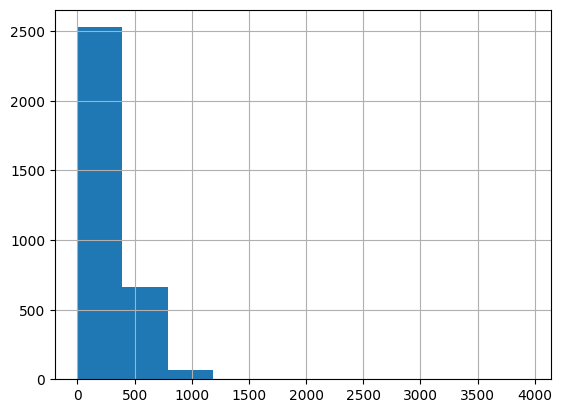

In [7]:
df_dish['total_calories'].hist()

<Axes: >

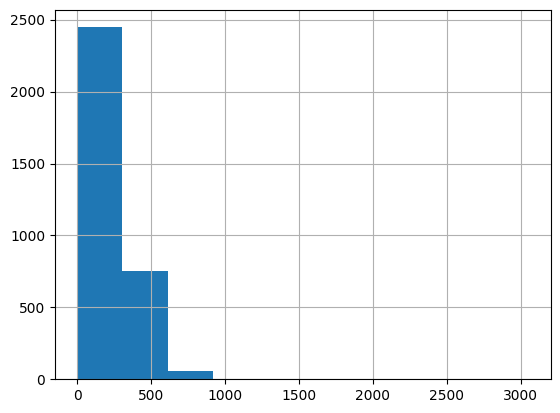

In [8]:
df_dish['total_mass'].hist()

In [9]:
image_paths= [f'{DATA_PATH}images/{p}/rgb.png' for p in os.listdir(f'{DATA_PATH}images/')]

In [10]:
image_paths[:4]

['data/images/dish_1564515049/rgb.png',
 'data/images/dish_1566328894/rgb.png',
 'data/images/dish_1562698209/rgb.png',
 'data/images/dish_1562788732/rgb.png']

In [11]:
def plot_sample_images(image_paths):
    _, axs = plt.subplots(3, 3, figsize=(5, 5))
    axs = axs.flatten()
    image_paths_sample = sample(image_paths, 9)
    imgs = [Image.open(img_path).convert('RGB') for img_path in image_paths_sample]
    for img, ax in zip(imgs, axs):
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(img)

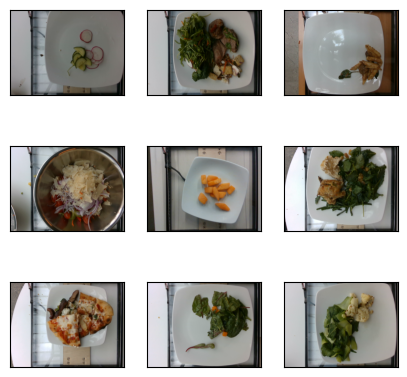

In [12]:
plot_sample_images(image_paths)

## 1.2 Обработка текстового описания - переход к токенам

In [13]:
dict_ingredients = {k:v for k, v in zip(df_ing['id'], df_ing['ingr'])}
dict_ingredients

{1: 'cottage cheese',
 2: 'strawberries',
 3: 'garden salad',
 4: 'bacon',
 5: 'potatoes',
 6: 'caesar salad',
 7: 'cauliflower',
 8: 'scrambled eggs',
 9: 'wild rice',
 10: 'steak',
 11: 'cheese pizza',
 12: 'olives',
 13: 'berries',
 14: 'asparagus',
 15: 'hash browns',
 16: 'brussels sprouts',
 17: 'pasta salad',
 18: 'turkey',
 19: 'bread',
 20: 'duck',
 21: 'squash',
 22: 'guacamole',
 23: 'brown rice',
 24: 'artic char',
 25: 'beef',
 26: 'white rice',
 27: 'broccoli',
 28: 'chicken',
 29: 'mixed greens',
 30: 'lettuce',
 31: 'cucumbers',
 32: 'tomatoes',
 33: 'bell peppers',
 34: 'celery',
 35: 'blue cheese',
 36: 'spinach (raw)',
 37: 'cantaloupe',
 38: 'pineapple',
 39: 'sausage',
 40: 'raspberries',
 41: 'blackberries',
 42: 'avocado',
 43: 'green beans',
 44: 'bean sprouts',
 45: 'carrot',
 46: 'mushroom',
 47: 'corn',
 48: 'ham',
 49: 'fish',
 50: 'tofu',
 51: 'shrimp',
 52: 'cheese',
 53: 'nuts',
 54: 'apple',
 55: 'banana',
 56: 'kiwi',
 57: 'lemon',
 58: 'orange',
 59: '

In [14]:
# def parse_ingredients(raw_text, dict_ingredients):
#     return ' '.join([dict_ingredients[int(t[12:])] for t in raw_text.split(';')])

def get_ingredients_idx(raw_text):
    return [int(t[12:]) for t in raw_text.split(';')]

In [15]:
df_dish['ingredients_idx'] = df_dish['ingredients'].apply(lambda x: get_ingredients_idx(x))

In [16]:
df_dish.head()

,dish_id,total_calories,total_mass,ingredients,split,ingredients_idx
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test,"[508, 122, 26, 524, 94, 23, 189, 54, 29, 328, ..."
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train,"[312, 26, 29, 122, 508, 513, 520, 525, 161, 94..."
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test,"[448, 520, 462, 514, 152, 312, 291, 45, 122, 6..."
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train,"[471, 31, 347]"
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train,[453]


## 1.3 Выделение валидационного сета

In [18]:
df_test = df_dish[df_dish['split'] == 'test'].reset_index(drop=True)

In [19]:
df_train, df_valid = train_test_split(df_dish[df_dish['split'] == 'train'], 
                                      test_size=0.15,)
df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

## 1.1 
- Как решать задачу: Мультимодальная нейросеть. Картинка + текст + масса блюда
- Аугментация/обогащение. Тексты: аугментация за счет перестановки токенов. Изображение: стандартные методы аугментации изображений
- Метрики -  MAE, RMSE, MAPE

# Этап 2. Реализуйте пайплайн обучения

## 2.1 Загрузчики данных и датасеты

In [20]:
df_ing.head()

,id,ingr
0,1,cottage cheese
1,2,strawberries
2,3,garden salad
3,4,bacon
4,5,potatoes


In [21]:
df_dish.head(3)

,dish_id,total_calories,total_mass,ingredients,split,ingredients_idx
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test,"[508, 122, 26, 524, 94, 23, 189, 54, 29, 328, ..."
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train,"[312, 26, 29, 122, 508, 513, 520, 525, 161, 94..."
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test,"[448, 520, 462, 514, 152, 312, 291, 45, 122, 6..."


## 2.2 Опциональный код предобработки/аугментации данных

In [23]:
text_model = "bert-base-uncased"
image_model = 'tf_efficientnet_b0'
tokenizer = AutoTokenizer.from_pretrained(text_model)
cfg = timm.get_pretrained_cfg(image_model)

In [24]:
transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=max(cfg.input_size[1], cfg.input_size[2]),
                          p=1.0),
        A.RandomCrop(height=cfg.input_size[1], width=cfg.input_size[2], p=1.0),
        A.Affine(scale=(0.8, 1.2),
                 rotate=(-15, 15),
                 translate_percent=(-0.1, 0.1),
                 shear=(-10, 10),
                 fill=0,
                 p=0.8),
        A.CoarseDropout(num_holes_range=(2, 8),
                        hole_height_range=(int(0.07 * cfg.input_size[1]),
                                           int(0.15 * cfg.input_size[1])),
                        hole_width_range=(int(0.1 * cfg.input_size[2]),
                                          int(0.15 * cfg.input_size[2])),
                        fill=0,
                        p=0.5),
        A.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.7),
        A.Normalize(mean=cfg.mean, std=cfg.std)
    ]
)

In [31]:
train_dataset = MultimodalDataset(df_train,
                       text_model=text_model,
                       image_model=image_model,
                       transforms=transforms,)
val_dataset = MultimodalDataset(df_valid,
                       text_model=text_model,
                       image_model=image_model,
                       transforms=transforms,)
test_dataset = MultimodalDataset(df_test,
                       text_model=text_model,
                       image_model=image_model,
                       transforms=transforms,)

In [32]:
train_loader = DataLoader(train_dataset,
                    batch_size=4,
                    shuffle=True,
                    collate_fn=partial(collate_fn, tokenizer=tokenizer))
train_loader = DataLoader(train_dataset,
                    batch_size=4,
                    shuffle=False,
                    collate_fn=partial(collate_fn, tokenizer=tokenizer))
train_loader = DataLoader(train_dataset,
                    batch_size=4,
                    shuffle=False,
                    collate_fn=partial(collate_fn, tokenizer=tokenizer))

## 2.3 Код обучения и валидации для импортирования в виде одной функции

###  Класс модели

In [ ]:
class BaseMultimodalModel(nn.Module):
    def __init__(self,
                 text_model_name='bert-base-uncased',
                 image_model_name='resnet50',
                 emb_dim=256):
        super().__init__()
        self.emb_dim = emb_dim
        self.text_model = AutoModel.from_pretrained(text_model_name)
        self.image_model = timm.create_model(
            image_model_name,
            pretrained=True,
            num_classes=0 
        )

        self.predictor = nn.Sequential(
            nn.Sequential(
            nn.Linear(
                in_features=self.text_model.config.hidden_size + self.image_model.num_features + 1, 
                out_features=256, 
                bias=True
            ),
            nn.LayerNorm(256),
            nn.Hardswish(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=256, out_features=1, bias=True),
) 
        )

    def forward(self, text_input, image_input, mass_input):
        text_features = self.text_model(**text_input).last_hidden_state[:,  0, :]
        image_features = self.image_model(image_input)
        mass_features = torch.tensor(mass_input).unsqueeze(1)
        # text_emb = self.text_proj(text_features)
        # image_emb = self.image_proj(image_features)
        print(text_features.shape, image_features.shape, mass_features.shape)
        multi_output = torch.cat([text_features, image_features, mass_features], dim=1)
        print(multi_output.shape)
        output = self.predictor(multi_output)
        print(output.shape)
        return output

In [55]:
text_model = AutoModel.from_pretrained('bert-base-uncased')
image_model = timm.create_model(
            'resnet50',
            pretrained=True,
            num_classes=0 
        )

In [ ]:
# class BaseMultimodalModel(nn.Module):
#     def __init__(self,
#                  text_model,
#                  image_model,
#                  emb_dim=256):
#         super().__init__()
#         self.emb_dim = emb_dim
#         self.text_model = text_model
#         self.image_model = image_model

#         self.predictor = nn.Sequential(
#             nn.Linear(
#                 in_features=self.text_model.config.hidden_size + self.image_model.num_features + 1, 
#                 out_features=256,  # 1024
#                 bias=True
#             ),
#             nn.LayerNorm(256),
#             nn.Hardswish(),
#             nn.Dropout(p=0.2),
#             nn.Linear(in_features=256,    # 1024
#                       out_features=1, 
#                       bias=True),
#         ) 
#         # self.classifier = nn.Sequential(
#         #     nn.Linear(emb_dim, emb_dim // 2),    # Уменьшение размерности
#         #     nn.LayerNorm(emb_dim // 2),          # Нормализация
#         #     nn.ReLU(),                           # Активация
#         #     nn.Dropout(0.15),                    # Регуляризация
#         #     nn.Linear(emb_dim // 2, num_classes) # Финальный слой
#         # )


#     def forward(self, text_input, image_input, mass_input):
#         text_features = self.text_model(**text_input).last_hidden_state[:,  0, :]
#         image_features = self.image_model(image_input)
#         mass_features = torch.tensor(mass_input).unsqueeze(1)

#         # print(text_features.shape, image_features.shape, mass_features.shape)
#         multi_output = torch.cat([text_features, image_features, mass_features], dim=1)
#         # print(multi_output.shape)
#         output = self.predictor(multi_output)
#         # print(output.shape)
#         return output

In [57]:
m = BaseMultimodalModel(text_model, image_model)

In [58]:
# 2 примера текста и картинки для инференса
tk = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenized = tk(["text", "text2"],
               return_tensors="pt",
               padding='max_length',
               truncation=True)

img = torch.randn(2, *m.image_model.pretrained_cfg["input_size"])

In [59]:
emb = m(tokenized, img, [44, 22])

In [60]:
emb

tensor([[-0.0232],
        [-0.0104]], grad_fn=<AddmmBackward0>)

###  А ТЕПЕРЬ ОБУЧЕНИЕ и ВАЛИДАЦИЯ

In [ ]:
class Config:
    # Модели
    TEXT_MODEL_NAME = "bert-base-uncased"
    IMAGE_MODEL_NAME = "resnet50"
    
    # Какие слои размораживаем - совпадают с неймингом в моделях
    TEXT_MODEL_UNFREEZE = "encoder.layer.11|pooler"  
    IMAGE_MODEL_UNFREEZE = "layer.3|layer.4"  
    
    # Гиперпараметры
    BATCH_SIZE = 32
    TEXT_LR = 3e-5
    IMAGE_LR = 1e-4
    CLASSIFIER_LR = 5e-4
    EPOCHS = 10
    DROPOUT = 0.3
    HIDDEN_DIM = 256
    NUM_CLASSES = 5
    
    # Пути
    TRAIN_DF_PATH = "path/train.csv"
    VAL_DF_PATH = "path/val.csv"
    SAVE_PATH = "best_model.pth" 

## 2.4 Конфиг-файл для запуска модели и сохранения результатов обучения

## 2.5 Код для получения воспроизводимых результатов (seed) с выводом метрик

# Этап 3. Обучение модели

## 3.1 Вызов метода обучения с передачей конфига

# Этап 4. Валидация

## 4.1 Расчет целевой метрики на тестовом датасете

## 4.2 Выведите топ-5 блюд, по которым оценка модели наименее точна. Опишите возможные причины низкого качества на этих примерах.

## 4.2 Выведите топ-5 блюд, по которым оценка модели наименее точна. Опишите возможные причины низкого качества на этих примерах.